In [2]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")




In [4]:
# sample_filename = './data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_filename = './data/BraTS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz'
# sample_filename_mask = './data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'
sample_filename_mask = './data/BraTS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [9]:
sample_filename2 = './data/BraTS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = './data/BraTS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = './data/BraTS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

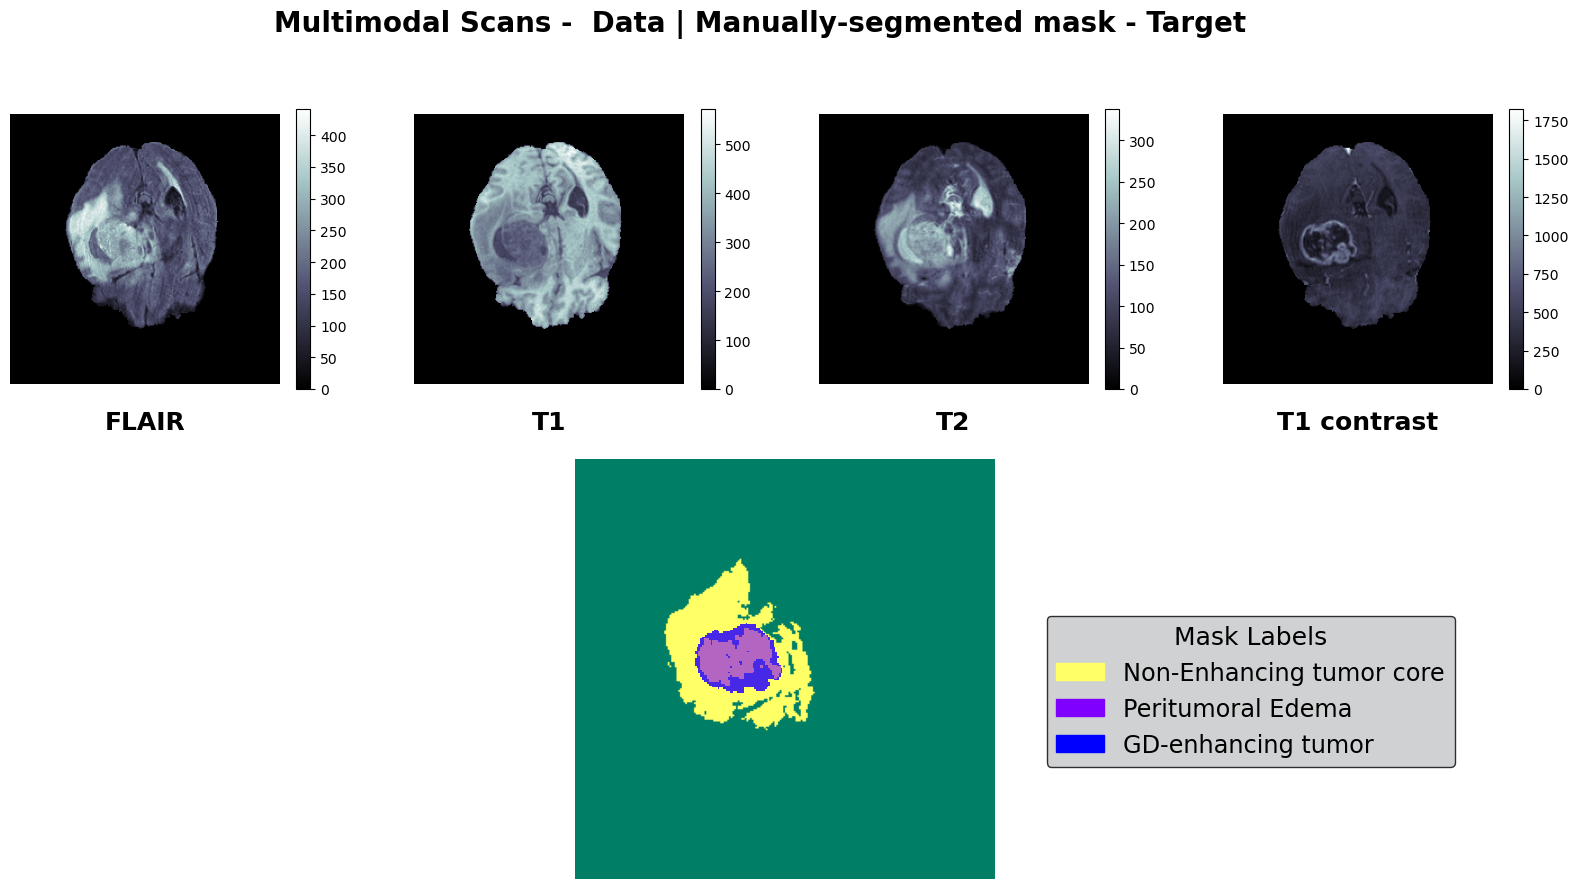

In [10]:
# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [8]:
from brats.configs.config import GlobalConfig, seed_everything
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

print(os.getcwd())
config = GlobalConfig()
seed_everything(config.seed)

survival_info_df = pd.read_csv('./data/BraTS2020/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('./data/BraTS2020/MICCAI_BraTS2020_TrainingData/name_mapping.csv')


name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

#split data on train, test, split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
#train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

/home/minee/BraTS
train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)


/home/minee/.conda/envs/ddpm/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  UserWarning,
